In [476]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120

In [471]:
%matplotlib widget

In [477]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time

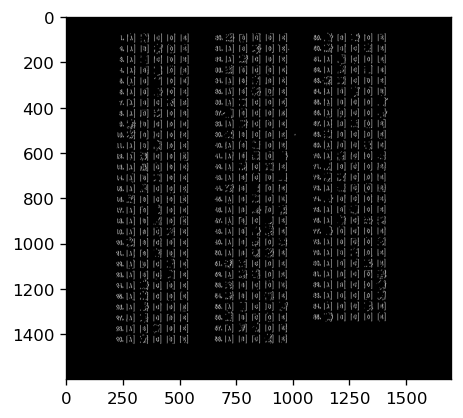

In [478]:
im = cv2.imread('../test-images/a-3.jpg')
gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5,5), 0)[600:,:]
(T, threshinv) = cv2.threshold(blurred, 200, 255, cv2.THRESH_BINARY_INV)

sobel_kernel = np.array([[1,2,1],[0,0,0],[-1,-2,-1]]).T
pf = cv2.filter2D(src=threshinv, ddepth=-1, kernel=sobel_kernel)

plt.imshow(pf, cmap='gray')

In [482]:
np.unique(pf.flatten())

array([  0, 255], dtype=uint8)

In [463]:
np.nonzero(pf)[0].shape

(107924,)

In [ ]:
d = np.linalg.norm(p2-p1)
points = p1.reshape(2,1) + (np.linspace(0,d)*((p2-p1)/d).reshape(2,1))
plt.imshow(threshinv, cmap='gray')
plt.plot(points[0,:], points[1,:], 'ro')

In [121]:
def show_lines(img, lines, title='img'):
    fig, axes = plt.subplots(figsize=(10,16))
    axes.imshow(img, cmap='gray')
    d = max(img.shape)
    for rho,theta in lines:
        dx = np.cos(theta)
        dy = np.sin(theta)
        x0 = dx*rho
        y0 = dy*rho
        # (x0,y0) is a point on the line
        # print(x0,y0)
        x1 = int(x0 + d*(-dy))
        y1 = int(y0 + d*(dx))
        x2 = int(x0 - d*(-dy))
        y2 = int(y0 - d*(dx))
        # print(x1,y1,x2,y2)
        axes.plot([x1,x2], [y1,y2], '-.', color='red', alpha=0.7)
    axes.set_xlim(0, img.shape[1]) # x is cols
    axes.set_ylim(img.shape[0], 0) # y is rows
    axes.set_title(title)

In [353]:
4*np.ceil(np.linalg.norm(threshinv.shape[:2]))

1452.0

In [386]:
np.array(list(zip(*np.nonzero(threshinv))))

array([[  75, 1151],
       [  75, 1152],
       [  76, 1145],
       ...,
       [1443,  469],
       [1443,  470],
       [1443,  474]])

In [414]:
num_rhos = 7
num_thetas = 5
num_edge_pixels = 10

acc = np.zeros((num_rhos, num_thetas))
theta_idxs = np.arange(num_thetas)
rho_mat = np.digitize(np.random.randint(0, 10, size=(num_edge_pixels,num_thetas)), bins=np.arange(7))-1
rho_mat

array([[1, 0, 1, 6, 6],
       [3, 6, 4, 6, 6],
       [6, 6, 5, 6, 6],
       [3, 5, 6, 6, 0],
       [2, 6, 6, 6, 6],
       [3, 6, 6, 6, 6],
       [0, 3, 4, 6, 6],
       [6, 4, 6, 0, 6],
       [6, 6, 6, 1, 2],
       [6, 6, 4, 5, 5]])

In [408]:
theta_idxs

array([0, 1, 2, 3, 4])

In [415]:
acc[rho_mat, theta_idxs] += 1

In [416]:
acc

array([[1., 1., 0., 1., 1.],
       [1., 0., 1., 1., 0.],
       [1., 0., 0., 0., 1.],
       [1., 1., 0., 0., 0.],
       [0., 1., 1., 0., 0.],
       [0., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

In [436]:
np.array(list(zip(*np.nonzero(threshinv)))).shape

(369633, 2)

https://alyssaq.github.io/2014/understanding-hough-transform/

https://alyssaq.github.io/2014/understanding-hough-transform/

In [465]:
def HoughLines(img, rho_res, theta_res, votes_threshold):
    start = time.time()
    # img - binary image, where edges are 1 and others are 0
    # rho_res - resolution of rho for the accumulator grid
    # theta_res - resolution of theta for the accumulator grid in radians
    # votes_threshold - return lines that have more than votes_threshold votes
    
    # grid thetas ranging from 0 to pi (range inclusive)
    thetas = np.arange(0, np.pi+theta_res, theta_res)
    thetas_idxs = np.arange(0, len(thetas))
    
    # grid rhos ranging from -diag to diag where diag = sqrt(w^2+h^2)
    diag = np.ceil(np.linalg.norm(img.shape[:2]))
    print('diag', diag)
    rhos = np.arange(-diag, diag+rho_res, rho_res)
    
    # create accumulator grid
    num_thetas, num_rhos = thetas.shape[0], rhos.shape[0]
    acc_grid = np.zeros((num_rhos, num_thetas), dtype=np.uint64)
    
    cos_thetas = np.cos(thetas)
    sin_thetas = np.sin(thetas)
    
    # for each edge pixel (pixel != 0)
    for y, x  in zip(*np.nonzero(img)):
        # calculate rho for each theta and update accumulator grid
        rho = x*cos_thetas + y*sin_thetas
        rho_idxs = np.digitize(rho, bins=rhos)-1
        acc_grid[rho_idxs, thetas_idxs] += 1
    
    rho_idxs, theta_idxs = np.nonzero(acc_grid>votes_threshold)
    lines = list(zip(rhos[rho_idxs], thetas[theta_idxs]))
    
    print('elapsed-end', time.time()-start)
    return lines, acc_grid, thetas, rhos

lines, acc_grid, thetas, rhos = HoughLines(pf, 1/4, np.pi/(4*180), 200)
threshinv.shape, acc_grid.shape, len(lines)

diag 2335.0
elapsed-end 10.809583187103271


((1600, 1700), (18681, 721), 356)

In [466]:
rho_idxs, theta_idxs = np.nonzero(acc_grid>450)
lines = list(zip(rhos[rho_idxs], thetas[theta_idxs]))
len(lines)

116

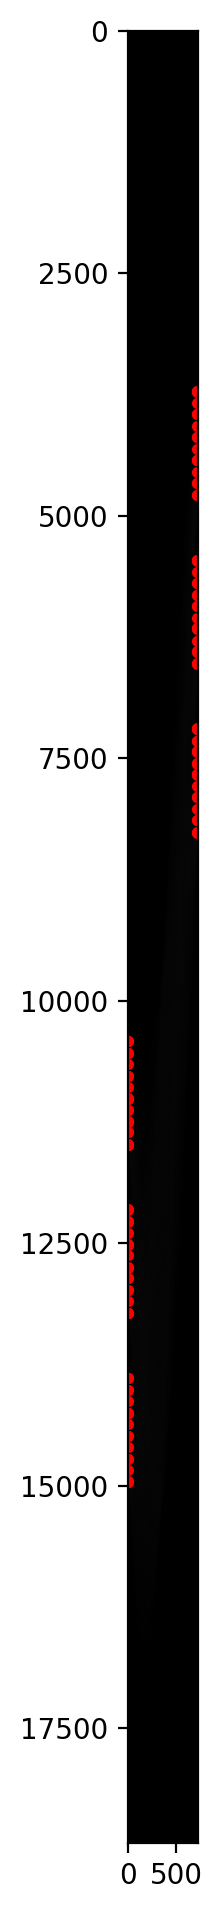

In [467]:
plt.figure(figsize=(6,12), dpi=200)
plt.imshow(acc_grid, cmap='gray')
plt.plot(theta_idxs,rho_idxs,  'r.')

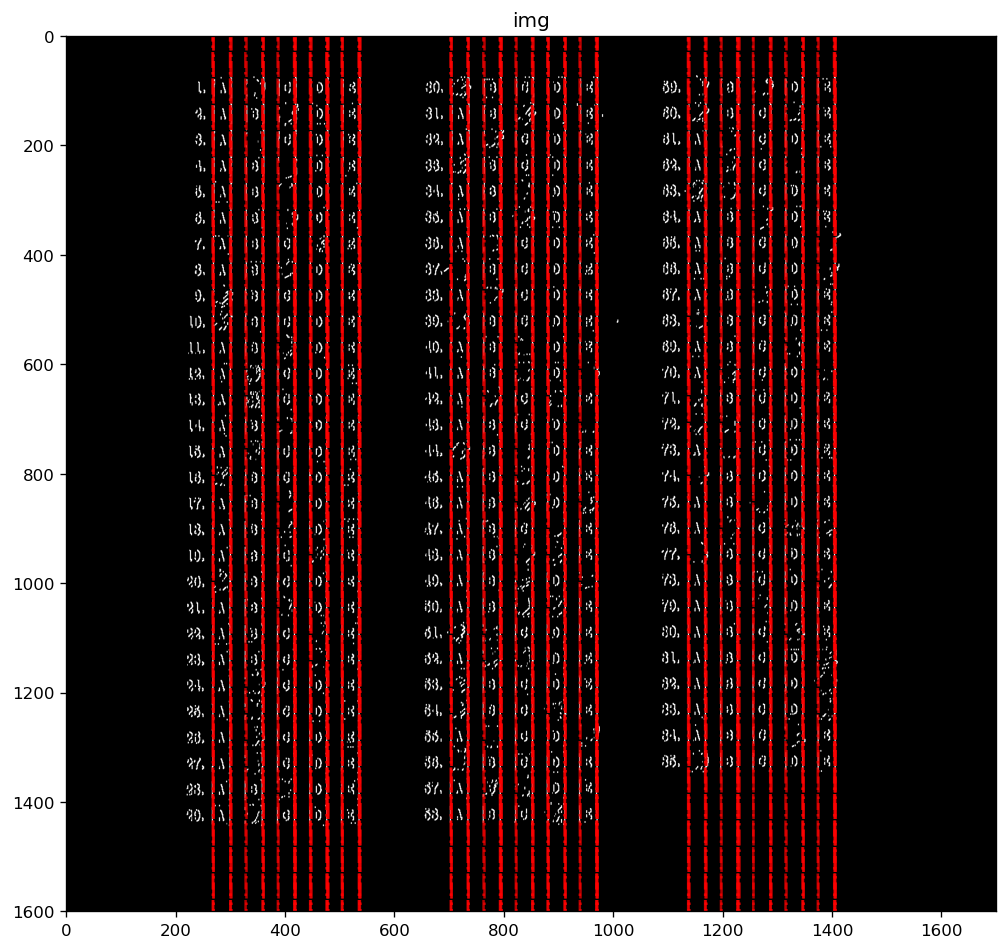

In [469]:
# lines = list(zip(rhos[rho_idxs], thetas[theta_idxs]))
show_lines(pf, lines)

In [357]:
lines_cv2 = cv2.HoughLines(threshinv, 1/2, np.pi/(180), 50).squeeze()

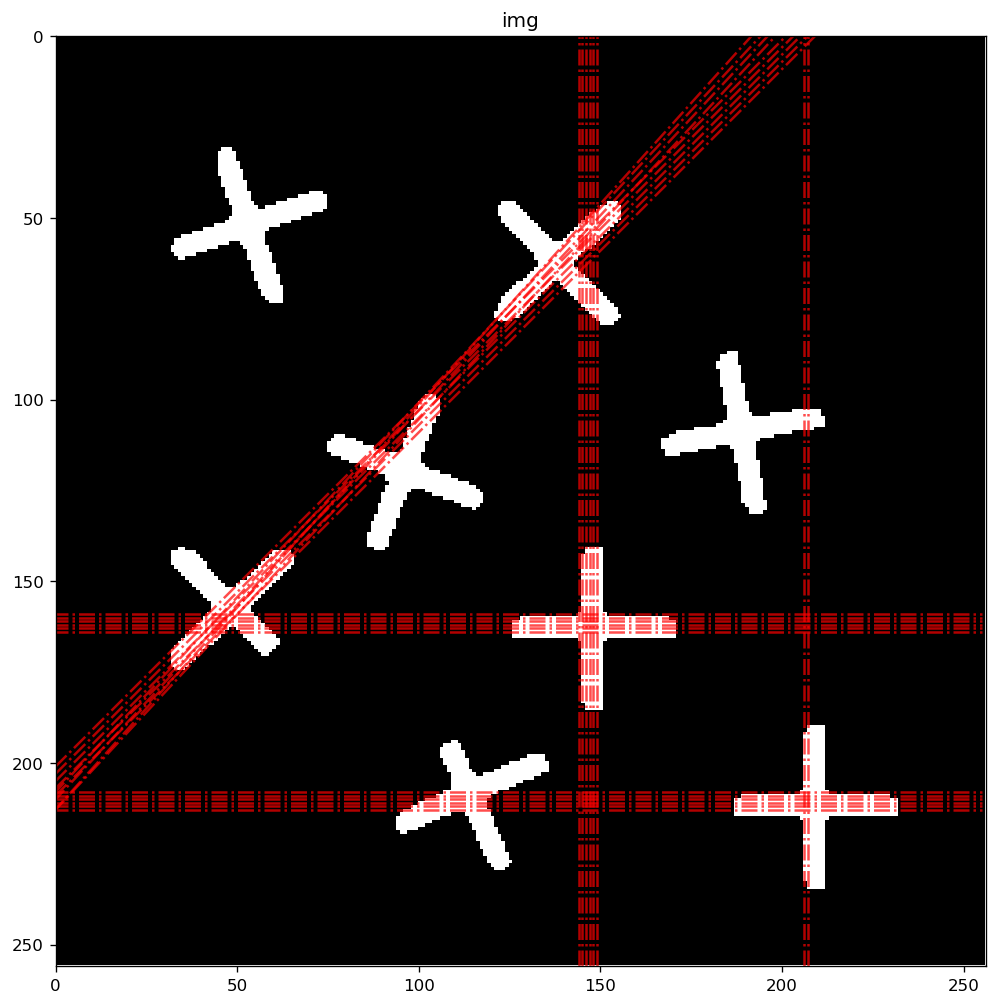

In [358]:
show_lines(threshinv, lines_cv2)